_Lambda School Data Science_

This sprint, your project is about water pumps in Tanzania. Can you predict which water pumps are faulty?

# Decision Trees

#### Objectives
- clean data with outliers
- impute missing values
- use scikit-learn for decision trees
- understand why decision trees are useful to model non-linear, non-monotonic relationships and feature interactions
- get and interpret feature importances of a tree-based model

#### Links

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)

### Libraries


#### category_encoders

You aren't required to use [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding), but it's recommended.

If you're working locally, you already installed it, probably with this shell command: `conda install -c conda-forge category_encoders` 

If you're using Google Colab, you need to reinstall it every time you restart all runtimes: `pip install category_encoders`


#### scikit-learn version 0.21.2

Until recently, scikit-learn required graphviz to visualize decision trees, and it could be a pain to install. But sklearn's newest versions have a [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) function that uses matplotlib!

Google Colab already has version 0.21.2. But if you're running Anaconda locally, you may need to upgrade.

You can check your version with this Python code: `import sklearn; print(sklearn.__version__)`

If necessary, you can update your version with this shell command: `conda update scikit-learn`

This isn't required to do your assignment, but it's required to run this lecture notebook.

#### pdpbox

[PDPbox](https://github.com/SauceCat/PDPbox) stands for "Partial Dependence Plot toolbox." It's a tool for model interpretation & visualization.

You can install it on Colab or locally with this shell command: `pip install pdpbox`

This also isn't required to do your assignment, but it's used in the lecture notebook.

#### pandas version downgraded to 0.23.4, to fix pivot table bug

For this lesson, I'll downgrade pandas from 0.24 to 0.23.4, because of a known issue: https://github.com/pandas-dev/pandas/issues/25087

I'm making a pivot table just for demonstration during this lesson, but it's not required for your assignment. So, you don't need to downgrade pandas if you don't want to.

## Clean data with outliers, impute missing values (example solutions)

In [13]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'

train = pd.merge(pd.read_csv(LOCAL + 'train_features.csv'), 
                 pd.read_csv(LOCAL + 'train_labels.csv'))
test = pd.read_csv(LOCAL + 'test_features.csv')
sample_submission = pd.read_csv(LOCAL + 'sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [14]:
#train.head()

Some of the locations are at ["Null Island"](https://en.wikipedia.org/wiki/Null_Island) instead of Tanzania.

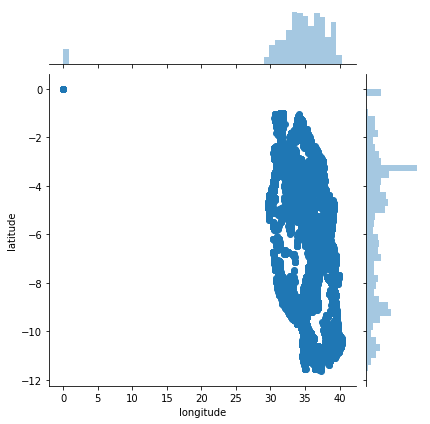

In [15]:
sns.jointplot(x='longitude', y='latitude', data=train);

In [16]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,47520.000000,47520.000000,47520.000000,47520.000000,4.752000e+04,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000
mean,37037.915699,321.925261,669.567656,34.082431,-5.705946e+00,0.477736,15.258291,5.616751,179.805513,1302.768939
std,21412.099719,3197.240487,693.005745,6.552053,2.941332e+00,13.312977,17.530228,9.621230,463.081564,950.955437
min,0.000000,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18482.750000,0.000000,0.000000,33.092142,-8.528215e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,36986.500000,0.000000,372.500000,34.910740,-5.021436e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55450.250000,25.000000,1320.000000,37.170578,-3.327185e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.344301,-2.000000e-08,1776.000000,99.000000,80.000000,15300.000000,2013.000000


#### Define a function to wrangle train, validate, and test sets in the same way.

Fix the location, and do more data cleaning and feature engineering.

In [17]:
train['construction_year'].mean()

1302.7689393939395

In [18]:
val['construction_year'].mean()

1292.1866161616163

In [19]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace them with the column mean.
    cols_with_zeros = ['construction_year', 'longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
#         X[col] = X[col].replace(0, X[col].mean())
        
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # for categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

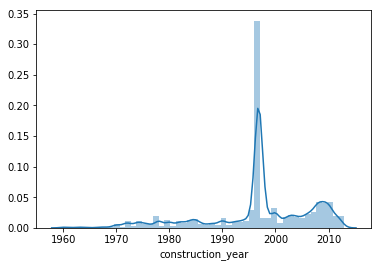

In [20]:
sns.distplot(train['construction_year']);

Now the locations look better.

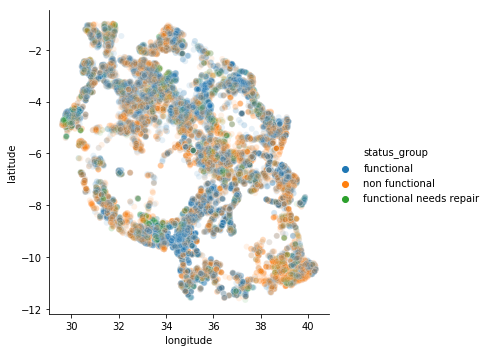

In [0]:
sns.relplot(x='longitude', y='latitude', hue='status_group', 
            data=train, alpha=0.1);

#### Select features

In [47]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 130].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
len(features)

32

#### Encode categoricals, scale features, fit and score Logistic Regression model, make predictions

In [48]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaler: fit_transform on train, transform on val & test
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Model: Fit on train, score on val, predict on test
model = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-02.csv', index=False)

Validation Accuracy 0.733922558922559


#### Get and plot coefficients

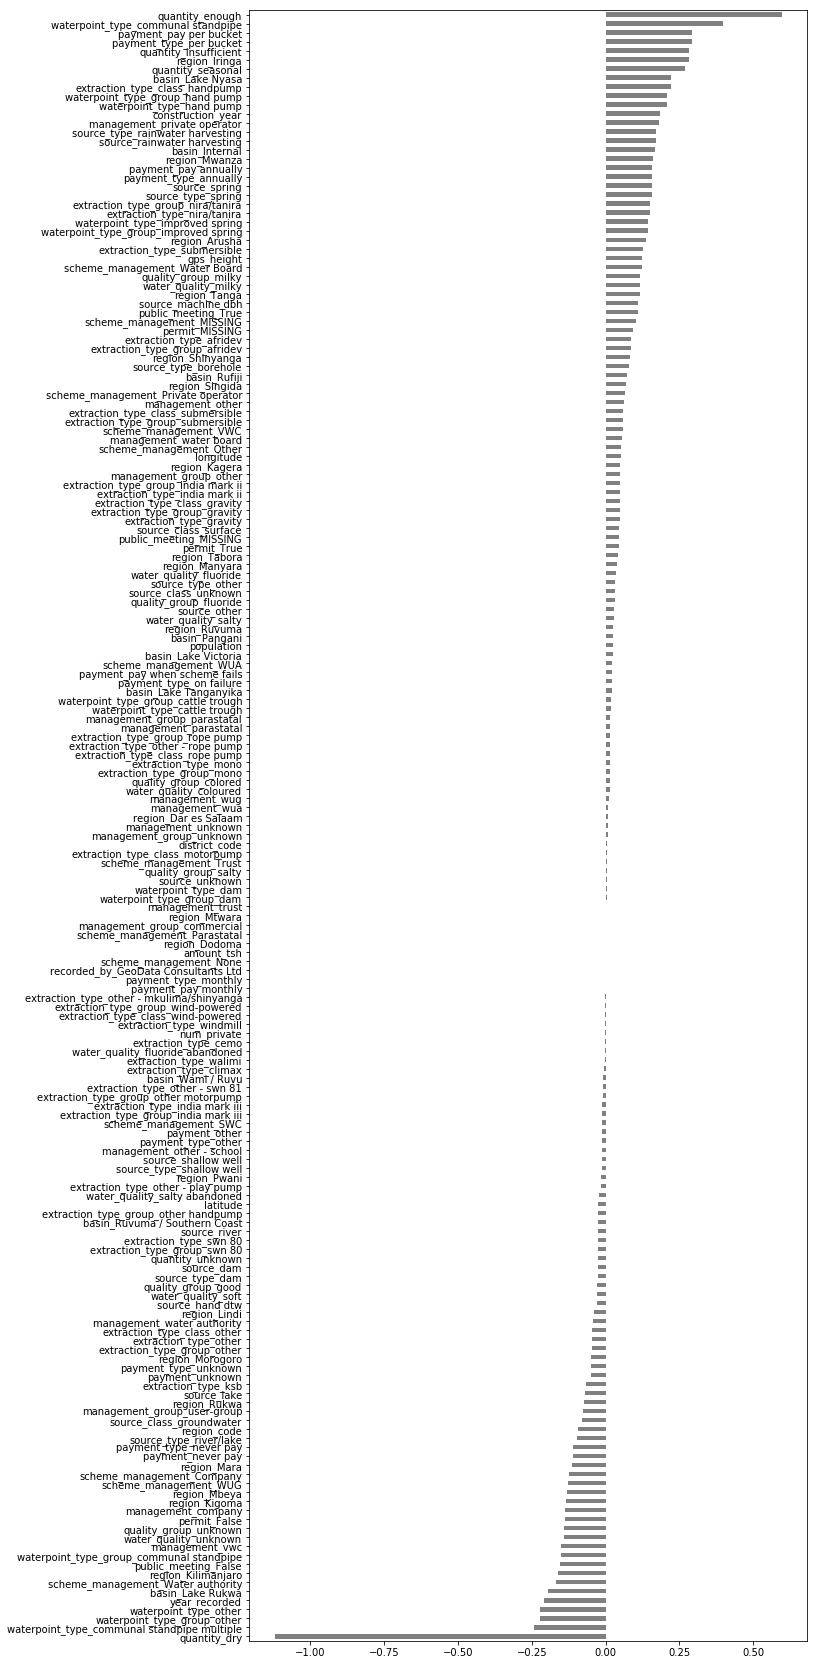

In [24]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

## Use scikit-learn for decision trees

### Compare a Logistic Regression with 2 features, longitude & latitude ...

In [49]:
train_location = X_train[['longitude', 'latitude']].copy()
val_location = X_val[['longitude', 'latitude']].copy()

In [50]:
lr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
lr.fit(train_location, y_train)
print('Logistic Regression:')
print('Train Accuracy', lr.score(train_location, y_train))
print('Validation Accuracy', lr.score(val_location, y_val))

Logistic Regression:
Train Accuracy 0.5430765993265994
Validation Accuracy 0.5430976430976431


### ... versus a Decision Tree Classifier with 2 features, longitude & latitude

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [52]:
val_location.shape, y_val.shape

((11880, 2), (11880,))

In [61]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
print('Decision Tree:')
print('Train Accuracy', dt.score(X_train_scaled, y_train))
print('Validation Accuracy', dt.score(X_val_scaled, y_val))

Decision Tree:
Train Accuracy 0.9959595959595959
Validation Accuracy 0.7593434343434343


In [78]:
dt = DecisionTreeClassifier(min_samples_leaf=25, random_state=42)
dt.fit(X_train_scaled, y_train)
print('Decision Tree:')
print('Train Accuracy', dt.score(X_train_scaled, y_train))
print('Validation Accuracy', dt.score(X_val_scaled, y_val))

Decision Tree:
Train Accuracy 0.8006734006734006
Validation Accuracy 0.7682659932659933


In [79]:
X_train_scaled

array([[ 0.        , -0.28219697, -0.42081054, ...,  0.        ,
         0.        ,  0.        ],
       [20.        ,  1.27007576, -0.12661848, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        , -0.0625    ,  0.80946438, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.17159091,  1.07784795, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.2       ,  0.0405303 ,  1.10028201, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.        ,  0.09734848,  0.63224119, ...,  0.        ,
         0.        ,  0.        ]])

## Understand why decision trees are useful to model non-linear, non-monotonic relationships and feature interactions

#### What does _(non)monotonic_ mean?!?!
- See Figures 1-3 in Wikipedia's article, [Monotonic function](https://en.wikipedia.org/wiki/Monotonic_function)
- See [World Population Growth, 1700-2010](https://ourworldindata.org/world-population-growth-past-future). World Population is non-linear and monotonic. Annual growth rate is non-linear and non-monotonic.
- See [Accidents per Mile Driven, by Driver Age](http://howwedrive.com/2009/02/20/whats-the-real-risk-of-older-drivers/). This is non-linear and non-monotonic.

#### What does _feature interactions_ mean?!?!
- See the explanation in [_Interpretable Machine Learning_, Chapter 5.4.1, Feature Interaction](https://christophm.github.io/interpretable-ml-book/interaction.html#feature-interaction).
- See the exploration in this notebook, under the heading ***Interlude #2: Simple housing***

### Visualize decision tree

https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html

In [103]:
#!pip install graphviz

### Interlude #1: predicting golf putts
(1 feature, non-linear, regression)

https://statmodeling.stat.columbia.edu/2008/12/04/the_golf_puttin/

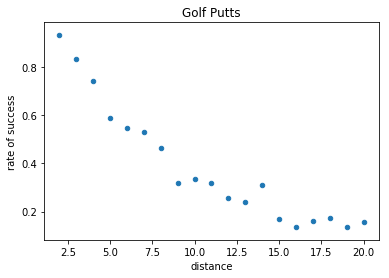

In [89]:
columns = ['distance', 'tries', 'successes']
data = [[2, 1443, 1346],
        [3, 694, 577],
        [4, 455, 337],
        [5, 353, 208],
        [6, 272, 149],
        [7, 256, 136],
        [8, 240, 111],
        [9, 217, 69],
        [10, 200, 67],
        [11, 237, 75],
        [12, 202, 52],
        [13, 192, 46],
        [14, 174, 54],
        [15, 167, 28],
        [16, 201, 27],
        [17, 195, 31],
        [18, 191, 33],
        [19, 147, 20],
        [20, 152, 24]]

putts = pd.DataFrame(columns=columns, data=data)
putts['rate of success'] = putts['successes'] / putts['tries']
putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts');

#### Compare Linear Regression ... 

R^2 Score 0.8695850610243295


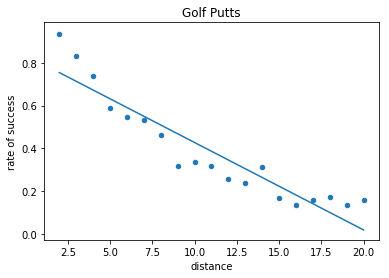

In [90]:
from sklearn.linear_model import LinearRegression

putts_X = putts[['distance']]
putts_y = putts['rate of success']
lr = LinearRegression()
lr.fit(putts_X, putts_y)
print('R^2 Score', lr.score(putts_X, putts_y))
ax = putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts')
ax.plot(putts_X, lr.predict(putts_X));

#### ... versus a Decision Tree Regressor
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [91]:
!pip install graphviz

### Interlude #2: Simple housing 
(2 features, regression)

https://christophm.github.io/interpretable-ml-book/interaction.html#feature-interaction

In [93]:
columns = ['Price', 'Good Location', 'Big Size']

data = [[300000, 1, 1], 
        [200000, 1, 0], 
        [250000, 0, 1], 
        [150000, 0, 0]]

house = pd.DataFrame(columns=columns, data=data)
house

,Price,Good Location,Big Size
0,300000,1,1
1,200000,1,0
2,250000,0,1
3,150000,0,0


#### Compare Linear Regression ... 

In [94]:
house_X = house.drop(columns='Price')
house_y = house['Price']
lr = LinearRegression()
lr.fit(house_X, house_y)
print('R^2', lr.score(house_X, house_y))
print('Intercept \t', lr.intercept_)
coefficients = pd.Series(lr.coef_, house_X.columns)
print(coefficients.to_string())

R^2 1.0
Intercept 	 150000.0
Good Location     50000.0
Big Size         100000.0


#### ... versus a Decision Tree Regressor

### Simple housing, with a twist: _Feature Interaction_

In [96]:
house.loc[0, 'Price'] = 400000
house_X = house.drop(columns='Price')
house_y = house['Price']
house

,Price,Good Location,Big Size
0,400000,1,1
1,200000,1,0
2,250000,0,1
3,150000,0,0


#### Compare Linear Regression ... 

In [97]:
lr = LinearRegression()
lr.fit(house_X, house_y)
print('R^2', lr.score(house_X, house_y))
print('Intercept \t', lr.intercept_)
coefficients = pd.Series(lr.coef_, house_X.columns)
print(coefficients.to_string())

R^2 0.9285714285714286
Intercept 	 125000.0
Good Location    100000.0
Big Size         150000.0


#### ... versus a Decision Tree Regressor

## Get and interpret feature importances of a tree-based model

In [99]:
model = DecisionTreeClassifier(max_depth=15, random_state=42)
model.fit(X_train_encoded, y_train)
print('Train Accuracy', model.score(X_train_encoded, y_train))
print('Validation Accuracy', model.score(X_val_encoded, y_val))

Train Accuracy 0.8243055555555555
Validation Accuracy 0.7651515151515151


In [100]:
X_train

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,year_recorded,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
43360,0.0,0,33.542898,-9.174777,0,12,4,0,1996.825469,2011,...,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
7263,500.0,2049,34.665760,-9.308548,0,11,4,175,2008.000000,2011,...,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
2486,25.0,290,38.238568,-6.179919,0,6,1,2300,2010.000000,2011,...,pay per bucket,per bucket,salty,salty,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
313,0.0,0,30.716727,-1.289055,0,18,1,0,1996.825469,2011,...,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other
52726,0.0,0,35.389331,-6.399942,0,1,6,0,1996.825469,2011,...,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
8558,0.0,1295,31.214583,-8.431428,0,15,2,200,1986.000000,2011,...,never pay,never pay,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
2559,20000.0,1515,36.696700,-3.337926,0,2,2,150,1995.000000,2013,...,pay monthly,monthly,soft,good,insufficient,spring,spring,groundwater,communal standpipe multiple,communal standpipe
54735,0.0,0,36.292724,-5.177333,0,1,1,0,1996.825469,2011,...,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
25763,0.0,0,32.877248,-8.925921,0,12,6,0,1996.825469,2011,...,never pay,never pay,soft,good,enough,machine dbh,borehole,groundwater,hand pump,hand pump
44540,0.0,0,33.014412,-3.115869,0,19,7,0,1996.825469,2011,...,pay monthly,monthly,soft,good,enough,machine dbh,borehole,groundwater,other,other


In [101]:
len(model.feature_importances_)

305

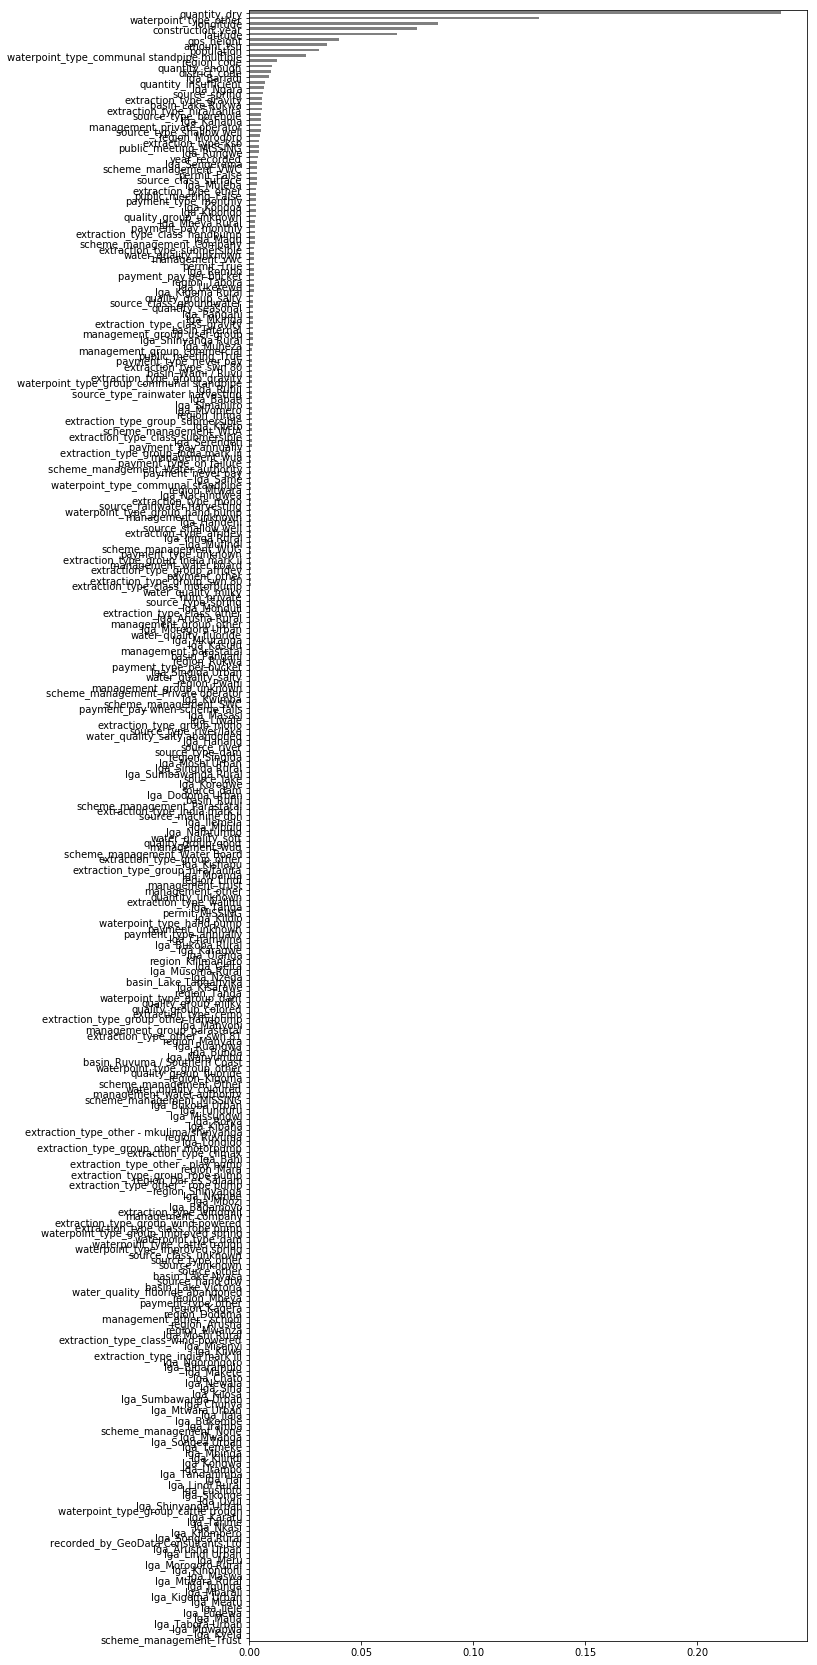

In [102]:
importances = pd.Series(model.feature_importances_, 
                        X_train_encoded.columns)

plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

# Assignment
- Start a clean notebook, or continue with yesterday's assignment notebook.
- Continue to participate in our Kaggle competition with the Tanzania Waterpumps data. 
- Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- Try a Decision Tree Classifier. 
- Submit new predictions.
- Commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- Create visualizations and share on Slack.
- Read more about decision trees and tree ensembles. You can start with the links at the top of this notebook.
- Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.
